In [41]:
import os
import time
import librosa
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from pathlib import Path
import keras
from keras.layers.normalization import BatchNormalization


In [16]:
# Walking a directory tree and getting the names and directories of the train and test files 
mydiclist={}
curr_path = os.getcwd()
crr_path = Path(curr_path)
parent_path = crr_path.parent
path= str(parent_path)+'\\data\\tone_cnn_8_emotions_dataset\\'


In [17]:
   """
        This function creates the dataset and saves both data and labels in
        two files, X.joblib and y.joblib in the joblib_features folder.
        With this method, you can persist your features and train quickly
        new machine learning models instead of reloading the features
        every time with this pipeline.
        """

lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
            try:
                # Load librosa array, obtain mfcss, store the file and the mcss information in a new array
                X, sample_rate = librosa.load(os.path.join(subdir, file),
                                                  res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate,
                                                         n_mfcc=40).T, axis=0)
                # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
                # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
                file = int(file[7:8]) - 1
                arr = mfccs, file
                lst.append(arr)
            # If the file is not valid, skip it
            except ValueError as err:
                print(err)
                continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

# Array conversion
X, y = np.asarray(X), np.asarray(y)

# Array shape check
print(X.shape, y.shape)


--- Data loaded. Loading time: 181.33810925483704 seconds ---
(5252, 40) (5252,)


In [18]:
X.shape

(5252, 40)

In [42]:
def create_model():
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same',
                         input_shape=(40, 1)))
    model.add(Conv1D(128, 5, padding='same',
                         input_shape=(40, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
        #model.add(MaxPooling1D(pool_size=(8)))
    model.add(Flatten())
    model.add(Dense(8))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    return model

In [43]:
def model2():
    model = Sequential()
    model.add(Conv1D(32, 5, padding='same',
                         input_shape=(40, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 5, padding='same',
                         input_shape=(40, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
       #model.add(MaxPooling1D(pool_size=(8)))
    model.add(Flatten())
    model.add(Dense(8))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    return model

In [44]:
   def train_neural_network(X, y) -> None:
        """
        This function trains the neural network.
        """

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        x_traincnn = np.expand_dims(X_train, axis=2)
        x_testcnn = np.expand_dims(X_test, axis=2)

        print(x_traincnn.shape, x_testcnn.shape)

        model = model2()
        print(model.summary)
        opt = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='sparse_categorical_crossentropy',#categorical_crossentropy sparse_categorical_crossentropy
                      optimizer= opt, #'rmsprop', #,#rmsprop #opt
                      metrics=['accuracy'])

        cnn_history = model.fit(x_traincnn, y_train,
                               batch_size=10, epochs=200,
                               validation_data=(x_testcnn, y_test))

        # Loss plotting
        plt.plot(cnn_history.history['loss'])
        plt.plot(cnn_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig('loss.png')
        plt.close()

        # Accuracy plotting
        plt.plot(cnn_history.history['accuracy'])
        plt.plot(cnn_history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('acc')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig('accuracy.png')

        predictions = model.predict_classes(x_testcnn)
        new_y_test = y_test.astype(int)
        matrix = confusion_matrix(new_y_test, predictions)

        print(classification_report(new_y_test, predictions))
        print(matrix)

        model_name = 'Emotion_Voice_Detection_Model.h5'

        # Save model and weights
        save_dir = os.path.join(os.getcwd(), 'saved_models')
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        model_path = os.path.join(save_dir, model_name)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)
        return model


(3518, 40, 1) (1734, 40, 1)
<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002A8591F6708>>
Epoch 1/200
352/352 [==============================] - 2s 6ms/step - loss: 1.4731 - accuracy: 0.5043 - val_loss: 0.9945 - val_accuracy: 0.6275
Epoch 2/200
352/352 [==============================] - 2s 6ms/step - loss: 1.0143 - accuracy: 0.6475 - val_loss: 0.8084 - val_accuracy: 0.7186
Epoch 3/200
352/352 [==============================] - 2s 6ms/step - loss: 0.8678 - accuracy: 0.6995 - val_loss: 0.8174 - val_accuracy: 0.6990
Epoch 4/200
352/352 [==============================] - 2s 6ms/step - loss: 0.7758 - accuracy: 0.7271 - val_loss: 0.6947 - val_accuracy: 0.7514
Epoch 5/200
352/352 [==============================] - 2s 6ms/step - loss: 0.7347 - accuracy: 0.7365 - val_loss: 0.6915 - val_accuracy: 0.7393
Epoch 6/200
352/352 [==============================] - 2s 6ms/step - loss: 0.6970 - accuracy: 0.7513 - val_loss: 0.6396 - val_accuracy: 0.7

Epoch 57/200
352/352 [==============================] - 2s 5ms/step - loss: 0.1880 - accuracy: 0.9346 - val_loss: 0.4275 - val_accuracy: 0.8604
Epoch 58/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1879 - accuracy: 0.9355 - val_loss: 0.4410 - val_accuracy: 0.8622
Epoch 59/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1920 - accuracy: 0.9309 - val_loss: 0.4555 - val_accuracy: 0.8535
Epoch 60/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1748 - accuracy: 0.9389 - val_loss: 0.4358 - val_accuracy: 0.8518
Epoch 61/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1758 - accuracy: 0.9360 - val_loss: 0.4414 - val_accuracy: 0.8587
Epoch 62/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1681 - accuracy: 0.9426 - val_loss: 0.4234 - val_accuracy: 0.8720
Epoch 63/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1663 - accuracy: 0.9372 - val_loss: 0.4297 - val_accuracy:

Epoch 114/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1027 - accuracy: 0.9639 - val_loss: 0.4785 - val_accuracy: 0.8697
Epoch 115/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1078 - accuracy: 0.9636 - val_loss: 0.4893 - val_accuracy: 0.8622
Epoch 116/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1147 - accuracy: 0.9616 - val_loss: 0.4491 - val_accuracy: 0.8743
Epoch 117/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0987 - accuracy: 0.9645 - val_loss: 0.4598 - val_accuracy: 0.8806
Epoch 118/200
352/352 [==============================] - 2s 6ms/step - loss: 0.1195 - accuracy: 0.9565 - val_loss: 0.4583 - val_accuracy: 0.8749
Epoch 119/200
352/352 [==============================] - 2s 5ms/step - loss: 0.1067 - accuracy: 0.9650 - val_loss: 0.4797 - val_accuracy: 0.8749
Epoch 120/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0931 - accuracy: 0.9667 - val_loss: 0.4763 - val_ac

352/352 [==============================] - 2s 6ms/step - loss: 0.0890 - accuracy: 0.9719 - val_loss: 0.4994 - val_accuracy: 0.8789
Epoch 171/200
352/352 [==============================] - 2s 5ms/step - loss: 0.0750 - accuracy: 0.9702 - val_loss: 0.4919 - val_accuracy: 0.8725
Epoch 172/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0710 - accuracy: 0.9750 - val_loss: 0.5042 - val_accuracy: 0.8720
Epoch 173/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0810 - accuracy: 0.9710 - val_loss: 0.5142 - val_accuracy: 0.8679
Epoch 174/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0719 - accuracy: 0.9770 - val_loss: 0.5031 - val_accuracy: 0.8766
Epoch 175/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0761 - accuracy: 0.9750 - val_loss: 0.5199 - val_accuracy: 0.8737
Epoch 176/200
352/352 [==============================] - 2s 6ms/step - loss: 0.0824 - accuracy: 0.9733 - val_loss: 0.5218 - val_accuracy: 0.8720

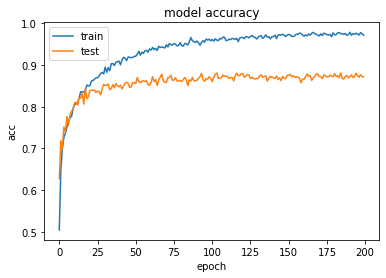

In [45]:
Trained_NN = train_neural_network(X=X, y=y)

## Saving the model

In [46]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
Trained_NN.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\InhouseProjects\ESA\model_training\git\audio-sentiment-analysis\prototypes\saved_models\Emotion_Voice_Detection_Model.h5 


In [47]:
import json
model_json = Trained_NN.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)